In [1]:
# Import av alle bibliotekene vi trenger for å løse oppgavene
import requests
import os
import pandas as pd
import missingno as msno
import sys

from dotenv import load_dotenv
from pandasql import sqldf


# Sett opp utviklingsmiljø
Før vi begynner har vi satt opp utviklingsmiljø. Vi har alle laget hver vår virtual environment. Disse gjør at vi kan jobbe hver for oss, uten å påvirke hverandre. 

In [2]:
# Oppgave 1: Sett opp utviklingsmiljø.

print("Utviklingsmiljøet er klart!")

Utviklingsmiljøet er klart!


# Datainnsamling

Vi har lastet ned et datasett fra Metrologisk institutt med api. API-en har vi kopiert fra nettsida. Vi har lagret hver får cliend-ID i en ENV-fil under navnet API-KEY. Denne trengs for å ta i bruk datasettet.

In [3]:
# Laster ned verdiene fra .env file.
load_dotenv()

# Henter Client_id fra .env.
api_key = os.getenv('API_KEY')

# Definerer endpoint og parametere.
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN18700,SN90450',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
    'referencetime': '2024-01-01/2025-01-01',
}
# Lager en HTTP GET request.
r = requests.get(endpoint, parameters, auth=(api_key,''))
# Henter JSON data
json = r.json()

# Skjekker om requesten fungerte og printer ut eventuelle feil.
if r.status_code == 200:
    data = json['data']
    print('Data er hentet fra frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

# Lagrer dataen i en Dataframe i et tabellformat.
df = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row])

df = df.reset_index()


Data er hentet fra frost.met.no!


# Databehandling

For å få et bedre innblikk i hva vi har data om har vi valgt å printe noen av de første linjene, finne ut hvor mange rader vi har og sett om vi har noen manglende verdier.

In [4]:
# .head(15) printer ut de femten første linjene av datasettet.   
df.head(15)

,index,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,0,mean(air_temperature P1D),-4.9,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2024-01-01T00:00:00.000Z,SN18700:0
1,1,mean(air_temperature P1D),-3.8,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2024-01-01T00:00:00.000Z,SN18700:0
2,2,sum(precipitation_amount P1D),10.4,mm,NaN,PT18H,P1D,0,C,2,NaN,2024-01-01T00:00:00.000Z,SN18700:0
3,3,sum(precipitation_amount P1D),6.3,mm,NaN,PT6H,P1D,0,C,2,0.0,2024-01-01T00:00:00.000Z,SN18700:0
4,4,mean(wind_speed P1D),6.9,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2024-01-01T00:00:00.000Z,SN18700:0
5,0,mean(air_temperature P1D),-7.4,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,0.0,2024-01-02T00:00:00.000Z,SN18700:0
6,1,mean(air_temperature P1D),-5.3,degC,"{'levelType': 'height_above_ground', 'unit': '...",PT6H,P1D,0,C,2,NaN,2024-01-02T00:00:00.000Z,SN18700:0
7,2,sum(precipitation_amount P1D),3.1,mm,NaN,PT18H,P1D,0,C,2,NaN,2024-01-02T00:00:00.000Z,SN18700:0
8,3,sum(precipitation_amount P1D),6.4,mm,NaN,PT6H,P1D,0,C,2,0.0,2024-01-02T00:00:00.000Z,SN18700:0
9,4,mean(wind_speed P1D),6.3,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,P1D,0,C,2,2.0,2024-01-02T00:00:00.000Z,SN18700:0


In [5]:
# .shape printer ut hvor mange rader og rekker vi har.
print('Shape', df.shape)

Shape (3660, 13)


<Axes: >

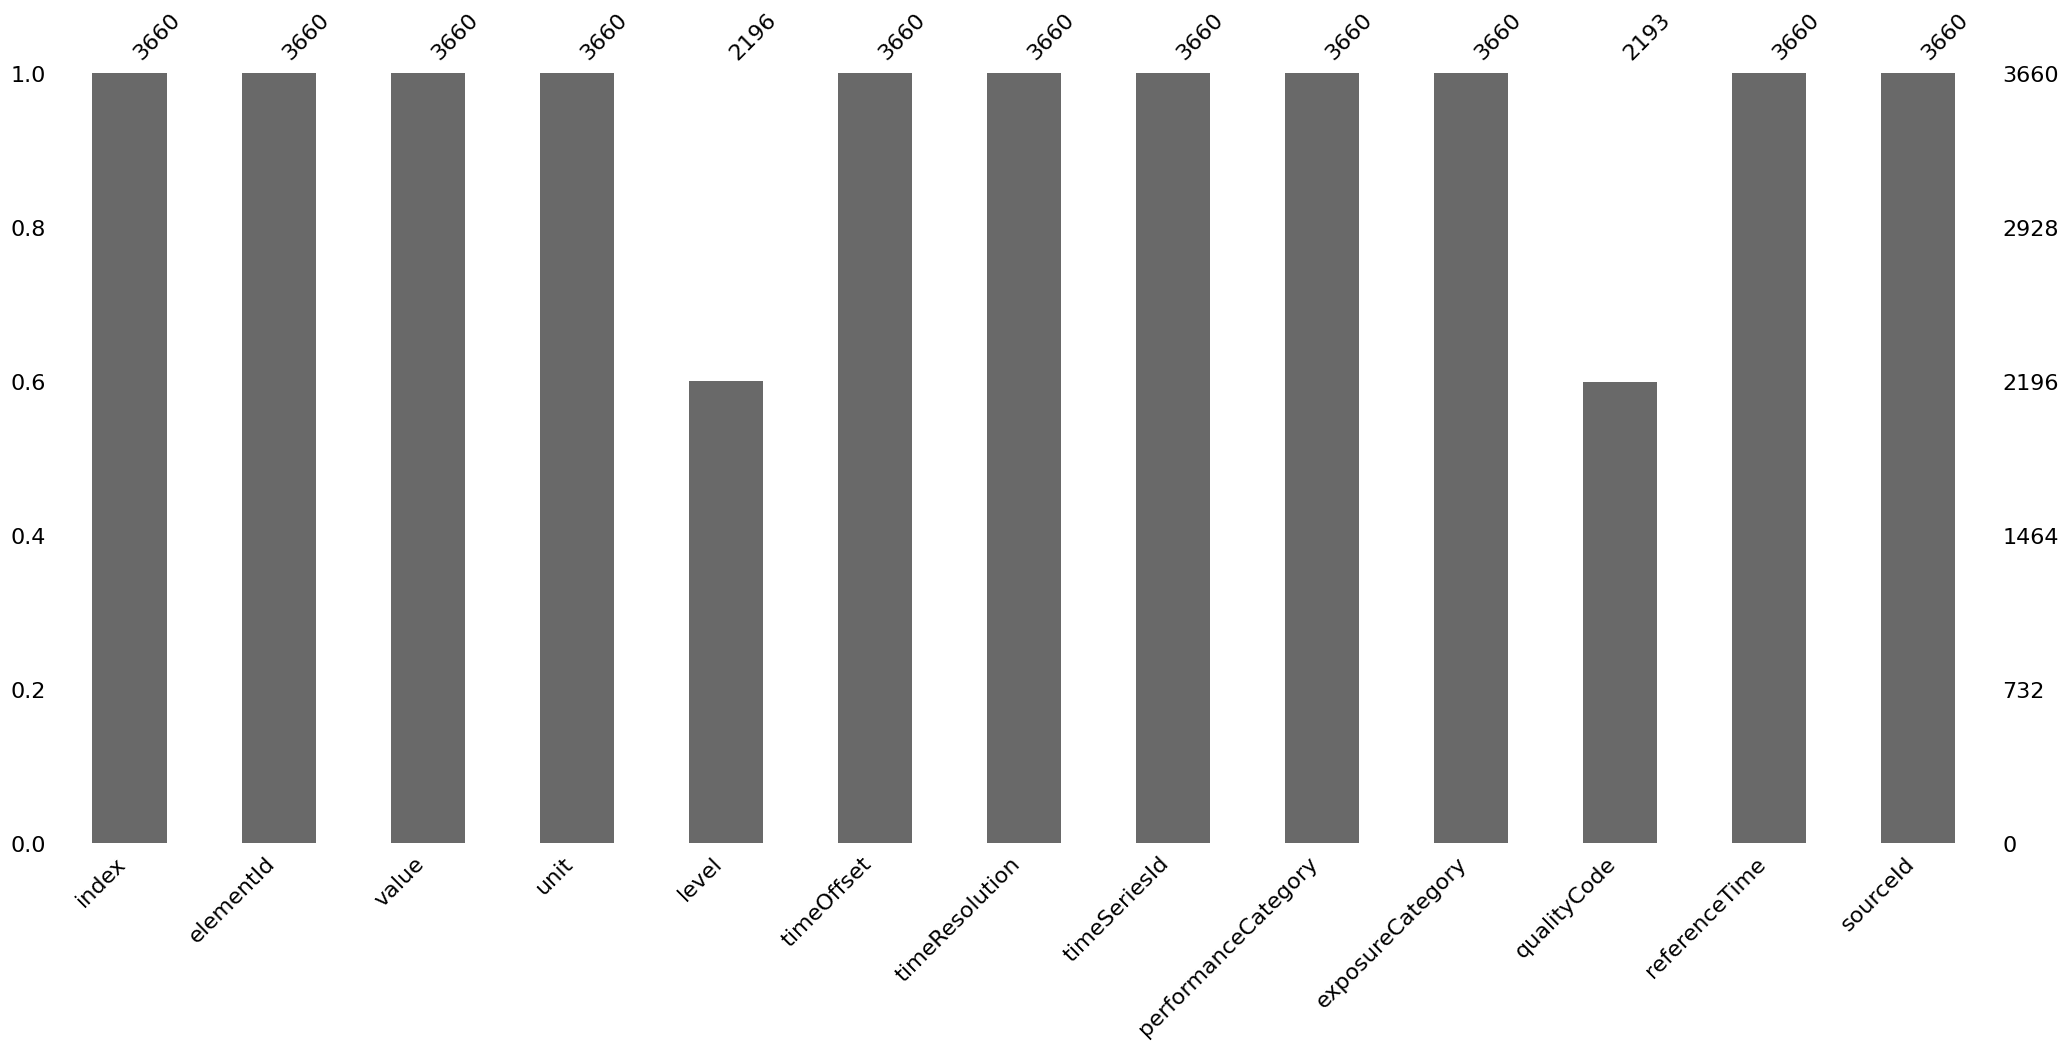

In [6]:
# Visualiserer om vi mangler noen verdier.
msno.bar(df)

Etter vi har blitt litt bedre kjent med dataen, har vi valgt å gå videre med bare fem av kolonnene. Vi har tatt med elementId, value, unit, timeOffset og referenceTime

In [7]:
# Lager en ny dataframe med utvalgte atributter.
sub_df = df[["elementId", "value", "unit", "timeOffset", "referenceTime"]]
sub_df

,elementId,value,unit,timeOffset,referenceTime
0,mean(air_temperature P1D),-4.9,degC,PT0H,2024-01-01T00:00:00.000Z
1,mean(air_temperature P1D),-3.8,degC,PT6H,2024-01-01T00:00:00.000Z
2,sum(precipitation_amount P1D),10.4,mm,PT18H,2024-01-01T00:00:00.000Z
3,sum(precipitation_amount P1D),6.3,mm,PT6H,2024-01-01T00:00:00.000Z
4,mean(wind_speed P1D),6.9,m/s,PT0H,2024-01-01T00:00:00.000Z
...,...,...,...,...,...
3655,mean(air_temperature P1D),-1.3,degC,PT0H,2024-12-31T00:00:00.000Z
3656,mean(air_temperature P1D),0.1,degC,PT6H,2024-12-31T00:00:00.000Z
3657,sum(precipitation_amount P1D),4.2,mm,PT18H,2024-12-31T00:00:00.000Z
3658,sum(precipitation_amount P1D),14.9,mm,PT6H,2024-12-31T00:00:00.000Z


Vi dobbeltsjekker at datasettet ikke har noen manglende verdier.

elementId        0
value            0
unit             0
timeOffset       0
referenceTime    0
dtype: int64

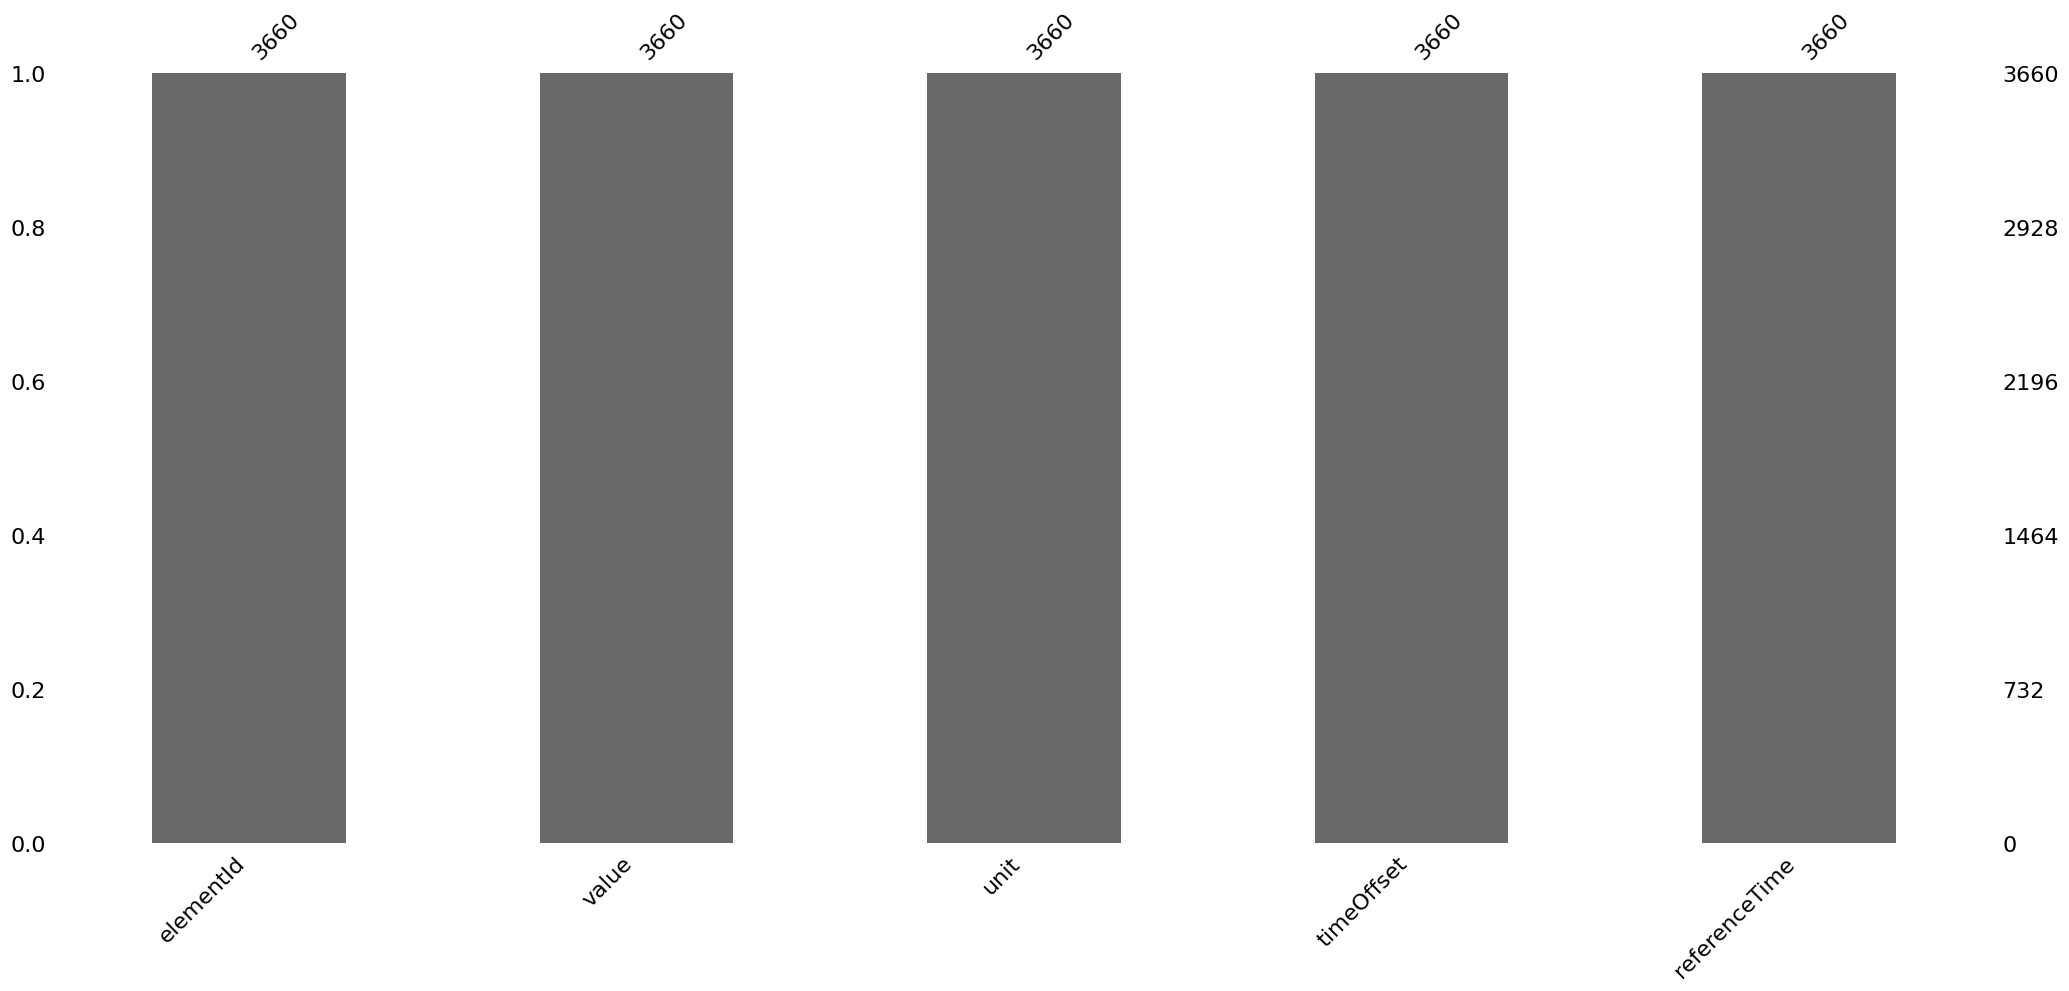

In [8]:
# Visualiserer manglende verdier i den nye dataframen.
msno.bar(sub_df)

# Sjekker om noen av kolonnene inneholder 0 
sub_df.isnull().sum()

Så sjekker vi om datasettet har noen duplikater. 

In [11]:
# Skjekker om vi har noen duplikater i datasettet
count_duplicates = sub_df.duplicated().sum()
print("Antall duplikater:", count_duplicates)

find_duplicates = sub_df[sub_df.duplicated()]
print(find_duplicates)

print(find_duplicates['referenceTime'])

Antall duplikater: 113
                          elementId  value unit timeOffset  \
1853  sum(precipitation_amount P1D)    0.0   mm       PT6H   
1908  sum(precipitation_amount P1D)    0.0   mm       PT6H   
1922  sum(precipitation_amount P1D)    0.0   mm      PT18H   
1928  sum(precipitation_amount P1D)    0.0   mm       PT6H   
1944           mean(wind_speed P1D)    3.0  m/s       PT0H   
...                             ...    ...  ...        ...   
3583  sum(precipitation_amount P1D)    1.6   mm       PT6H   
3602  sum(precipitation_amount P1D)    0.0   mm      PT18H   
3609           mean(wind_speed P1D)    1.8  m/s       PT0H   
3617  sum(precipitation_amount P1D)    0.0   mm      PT18H   
3623  sum(precipitation_amount P1D)    0.0   mm       PT6H   

                 referenceTime  
1853  2024-01-05T00:00:00.000Z  
1908  2024-01-16T00:00:00.000Z  
1922  2024-01-19T00:00:00.000Z  
1928  2024-01-20T00:00:00.000Z  
1944  2024-01-23T00:00:00.000Z  
...                        ...  
3

Det vises at datasettet har flere dukpikater, men det stemmer ikke helt, siden referansetiden er ulik. 

Vi har valgt å skifte noen kolonnenavnene til norsk, fordi vi da har bedre forståelse over hva de betyr. Dette er de kolonnene vi kommer til å ta med vidre i analysen.

In [ ]:
# Gir nye navn til noen av kolonnene til det nye dataframen. 
sub_df.rename(columns={"value": "verdi", "timeOffset" : "tidsforskyvning", "referenceTime": "referansetid"}, inplace = True)
sub_df

C:\Users\sofie\AppData\Local\Temp\ipykernel_30464\1961264689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.rename(columns={"value": "verdi", "timeOffset" : "tidsforskyvning", "referenceTime": "referansetid"}, inplace = True)


,elementId,verdi,unit,tidsforskyvning,referansetid
0,mean(air_temperature P1D),-4.9,degC,PT0H,2024-01-01T00:00:00.000Z
1,mean(air_temperature P1D),-3.8,degC,PT6H,2024-01-01T00:00:00.000Z
2,sum(precipitation_amount P1D),10.4,mm,PT18H,2024-01-01T00:00:00.000Z
3,sum(precipitation_amount P1D),6.3,mm,PT6H,2024-01-01T00:00:00.000Z
4,mean(wind_speed P1D),6.9,m/s,PT0H,2024-01-01T00:00:00.000Z
...,...,...,...,...,...
3655,mean(air_temperature P1D),-1.3,degC,PT0H,2024-12-31T00:00:00.000Z
3656,mean(air_temperature P1D),0.1,degC,PT6H,2024-12-31T00:00:00.000Z
3657,sum(precipitation_amount P1D),4.2,mm,PT18H,2024-12-31T00:00:00.000Z
3658,sum(precipitation_amount P1D),14.9,mm,PT6H,2024-12-31T00:00:00.000Z


Datasettet inneholder tre ulike elementtyper. Vi har valgt å dele datasettet inn i disse tre og lagre de i egne CSV-filer. Siden vi er tre på gruppa har vi da et datasett hver å jobbe med i resten av analysen.

In [ ]:
# Henter ut bare temperatur dataene.
query_temperature = f"""
    SELECT verdi, tidsforskyvning, referansetid
    FROM sub_df
    WHERE elementId LIKE 'mean(air_temperature P1D)'
    """

temperature = sqldf(query_temperature)
print(temperature)

# Legger temperatur dataene til en egen csv-fil.
temperature.to_csv('../data/temperature.csv', index=True)

# Bruker SQL spørringer til å hente ut bare nedbør dataene.
query_precipitation = f"""
    SELECT verdi, tidsforskyvning, referansetid
    FROM sub_df
    WHERE elementId LIKE 'sum(precipitation_amount P1D)'
    """

precipitation = sqldf(query_precipitation)
print(precipitation)

# Legger nedbør dataene til en egen csv-fil.
precipitation.to_csv('../data/precipitation.csv', index=True)



# Henter ut bare vind dataene.
query_wind = f"""
    SELECT verdi, tidsforskyvning, referansetid
    FROM sub_df
    WHERE elementId LIKE 'mean(wind_speed P1D)'
    """
wind = sqldf(query_wind)
print(wind)

# Legger vind dataene til en egen csv-fil.
wind.to_csv('../data/wind.csv', index=True)

      verdi tidsforskyvning              referansetid
0      -4.9            PT0H  2024-01-01T00:00:00.000Z
1      -3.8            PT6H  2024-01-01T00:00:00.000Z
2      -7.4            PT0H  2024-01-02T00:00:00.000Z
3      -5.3            PT6H  2024-01-02T00:00:00.000Z
4      -8.5            PT0H  2024-01-03T00:00:00.000Z
...     ...             ...                       ...
1459    2.8            PT6H  2024-12-29T00:00:00.000Z
1460    0.2            PT0H  2024-12-30T00:00:00.000Z
1461    1.0            PT6H  2024-12-30T00:00:00.000Z
1462   -1.3            PT0H  2024-12-31T00:00:00.000Z
1463    0.1            PT6H  2024-12-31T00:00:00.000Z

[1464 rows x 3 columns]
      verdi tidsforskyvning              referansetid
0      10.4           PT18H  2024-01-01T00:00:00.000Z
1       6.3            PT6H  2024-01-01T00:00:00.000Z
2       3.1           PT18H  2024-01-02T00:00:00.000Z
3       6.4            PT6H  2024-01-02T00:00:00.000Z
4       1.2           PT18H  2024-01-03T00:00:00.000Z
...